Running in Google Colab
X_train shape: (60000, 28, 28, 1)
y_train shape: (60000,)
X_test shape: (10000, 28, 28, 1)
y_test shape: (10000,)
Initializing CNN model...
Initializing CNN weights...
Weights initialized!
Model initialized!
Starting training for 15 epochs with 937 batches per epoch
  Processing batch 0/937
  Processing batch 100/937
  Processing batch 200/937
  Processing batch 300/937
  Processing batch 400/937
  Processing batch 500/937
  Processing batch 600/937
  Processing batch 700/937
  Processing batch 800/937
  Processing batch 900/937
Epoch 1/15, Loss: 0.8547, Accuracy: 0.7264
  Processing batch 0/937
  Processing batch 100/937
  Processing batch 200/937
  Processing batch 300/937
  Processing batch 400/937
  Processing batch 500/937
  Processing batch 600/937
  Processing batch 700/937
  Processing batch 800/937
  Processing batch 900/937
Epoch 2/15, Loss: 0.5728, Accuracy: 0.8056
  Processing batch 0/937
  Processing batch 100/937
  Processing batch 200/937
  Proces

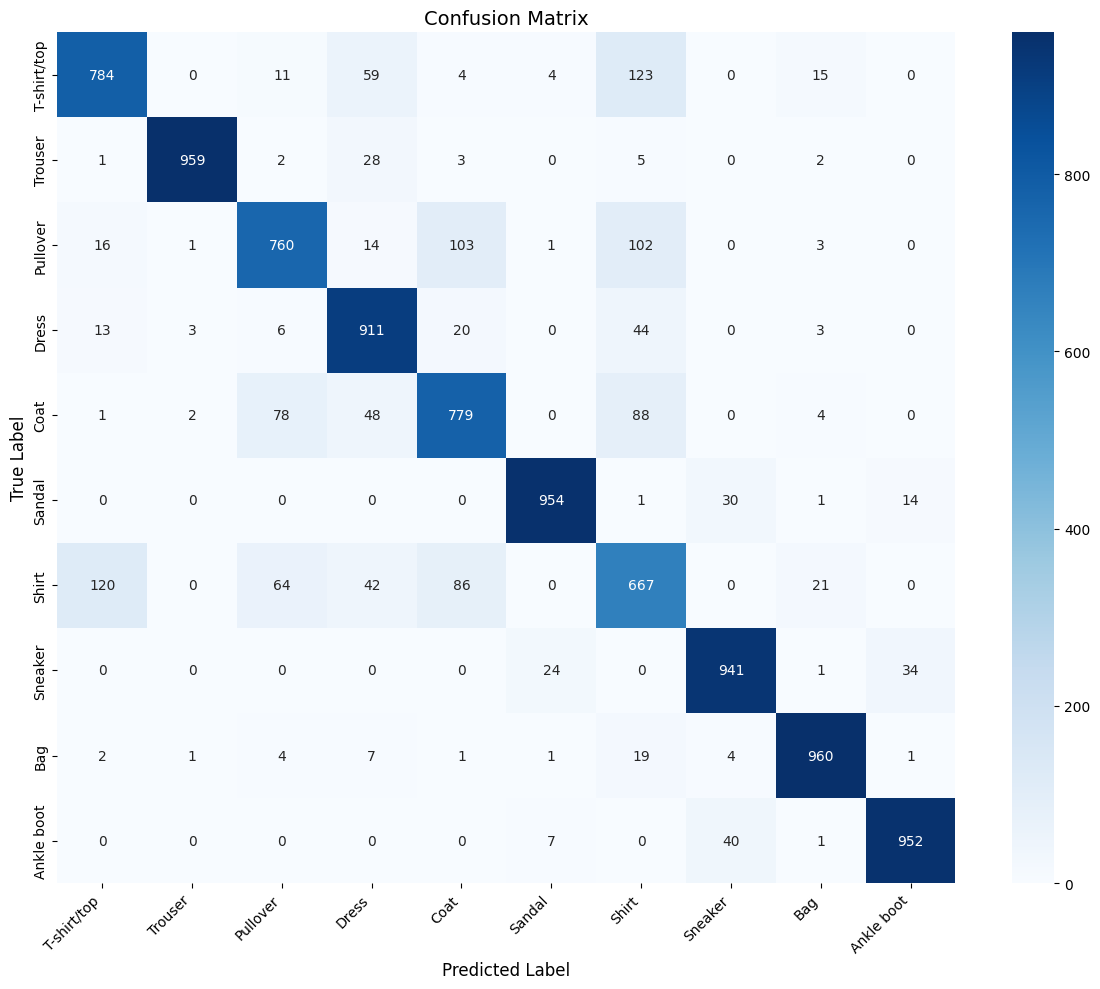

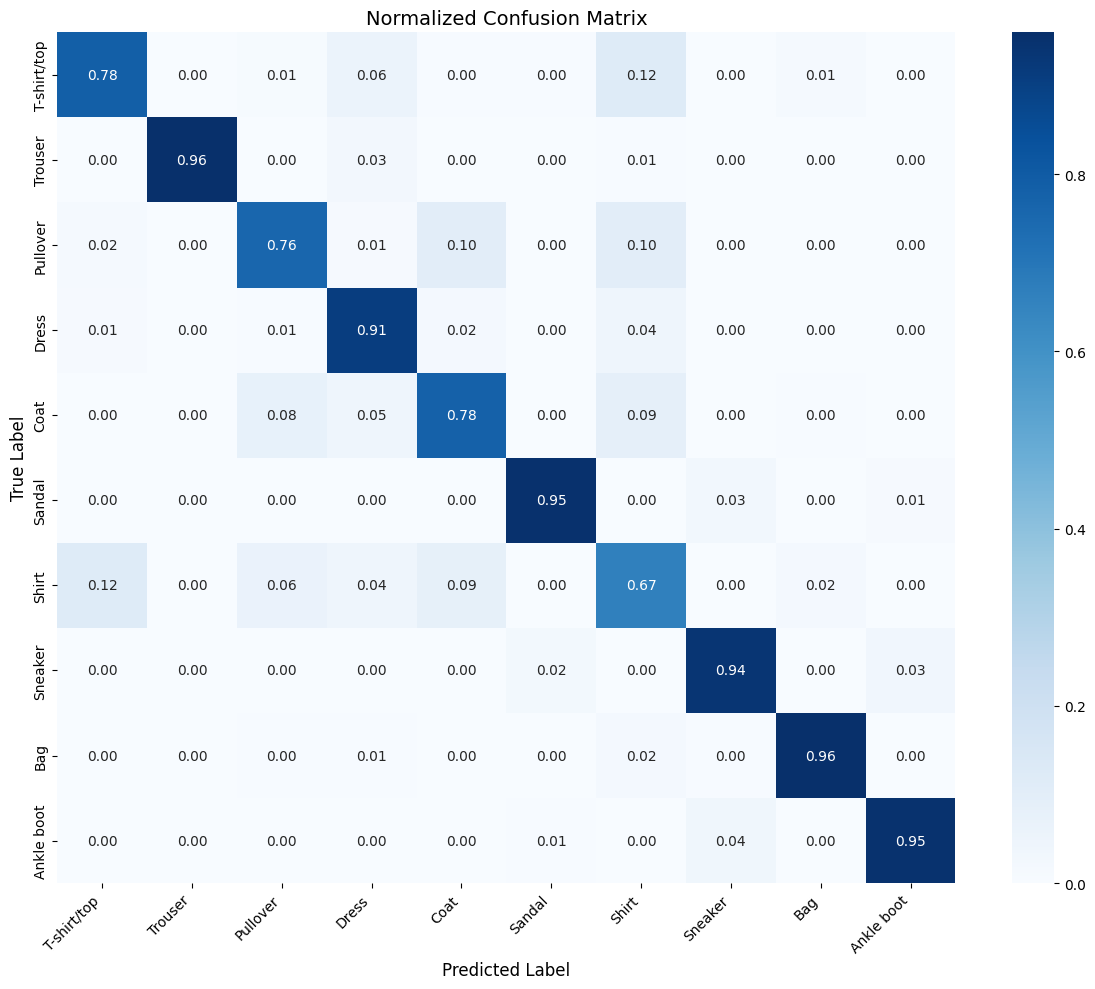

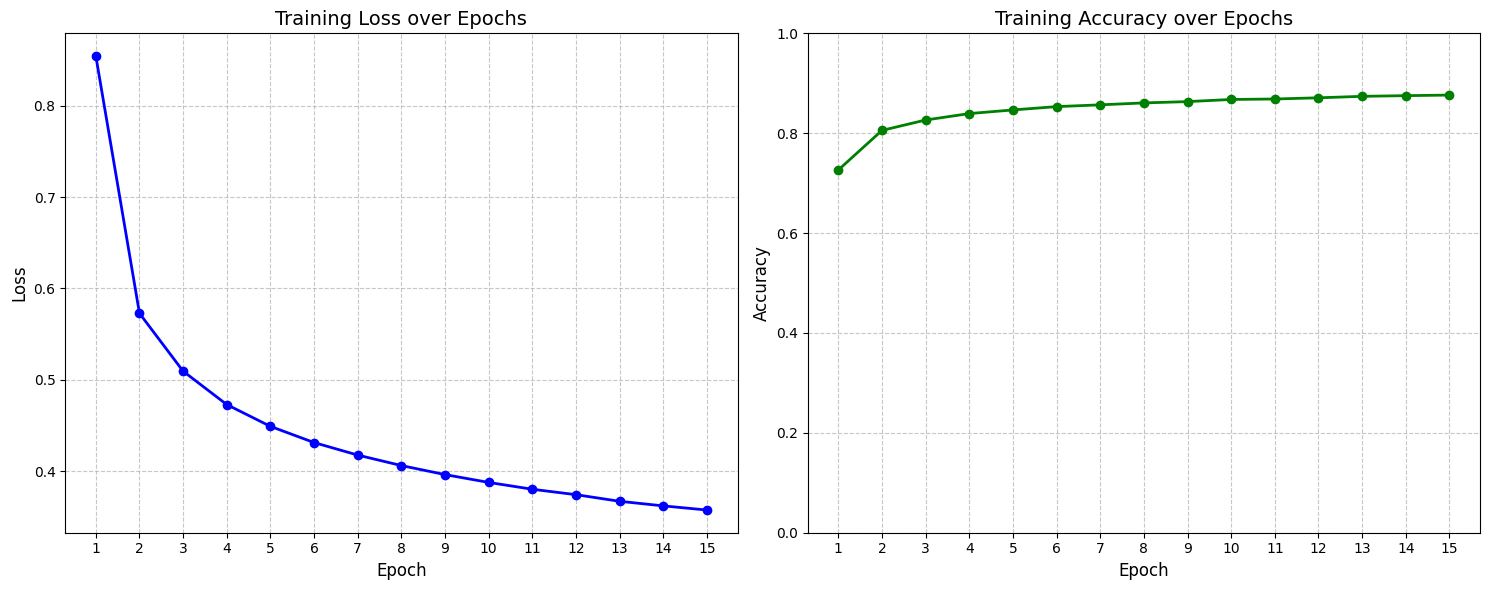

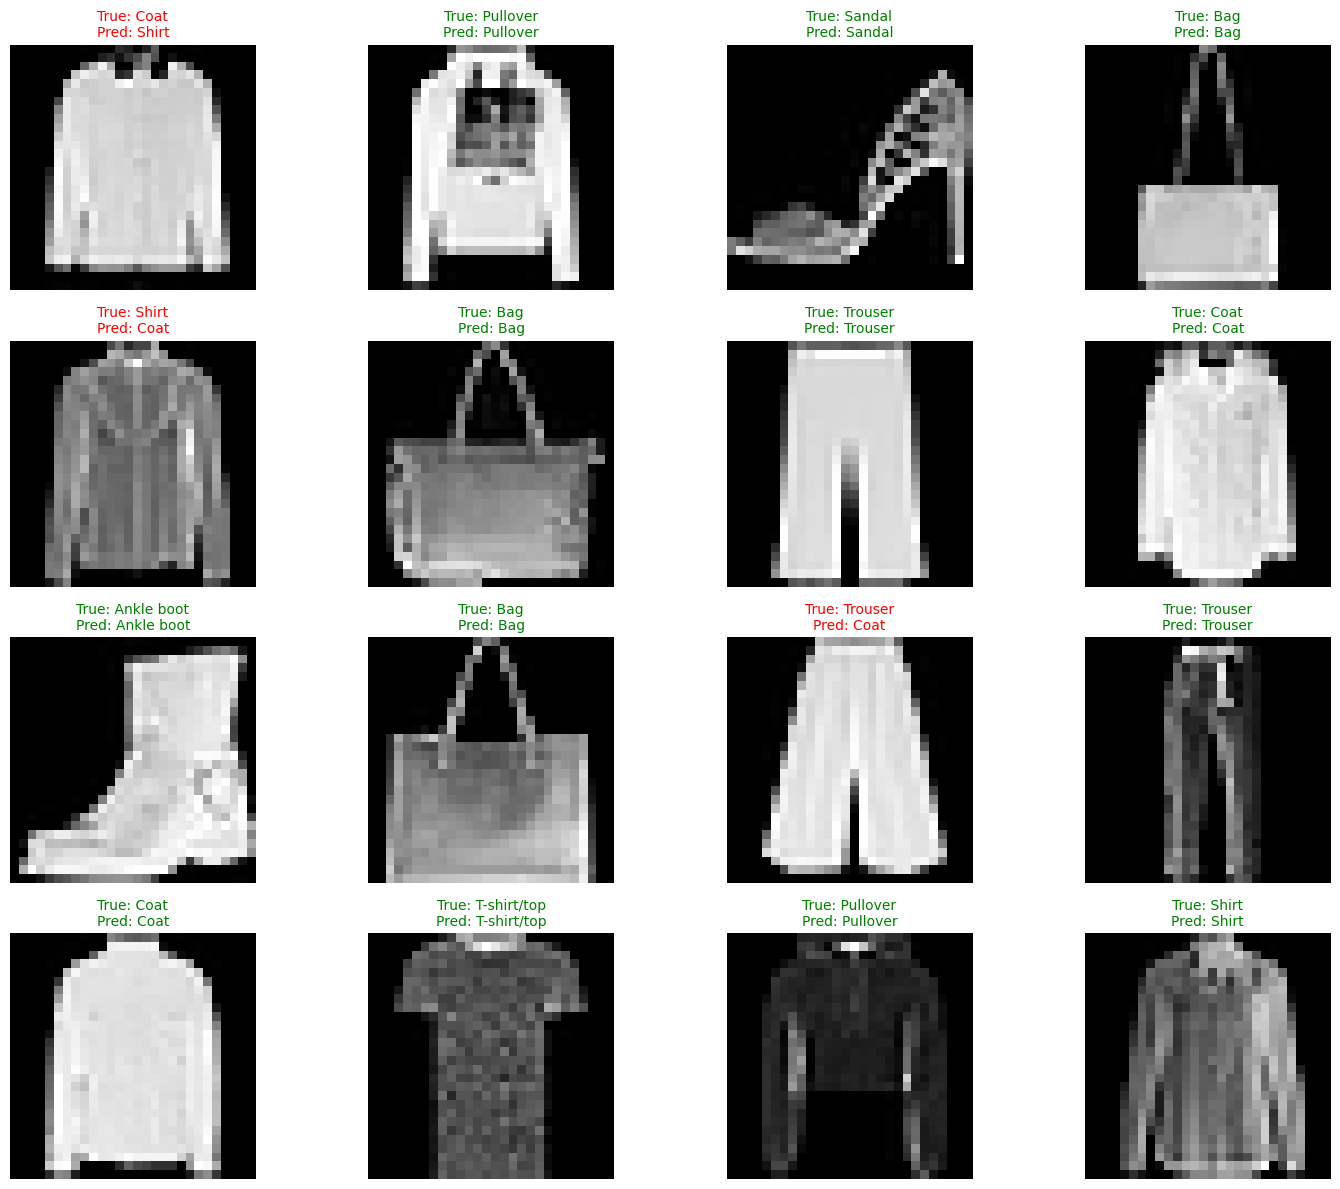

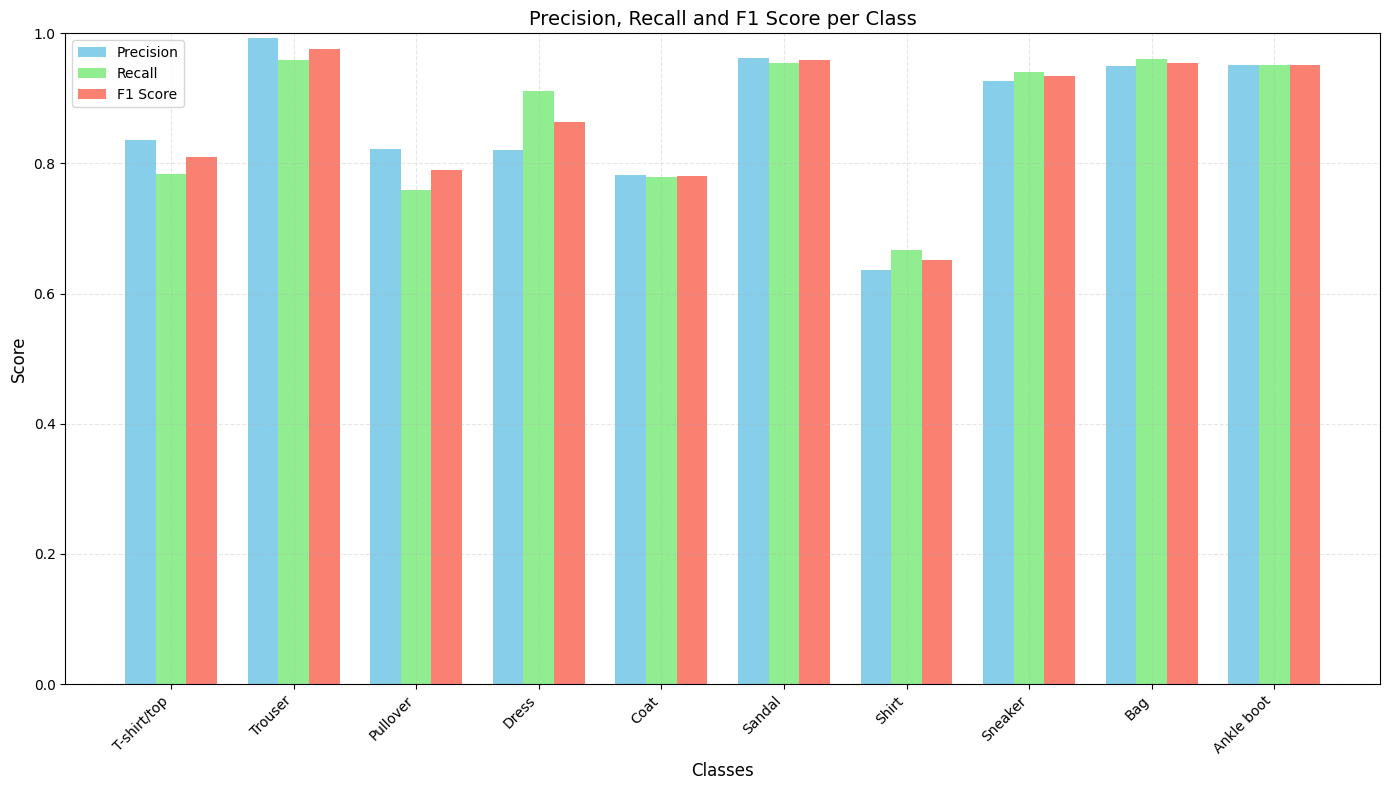

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import time

# For Google Colab, ensure we have all necessary packages
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
    # Make sure we have seaborn
    !pip install -q seaborn
except:
    IN_COLAB = False
    print("Not running in Google Colab")

# Class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Load Fashion MNIST dataset (only using tf.keras for this part)
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize the data (scale pixels between 0 and 1)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape data to include channel dimension (needed for convolutions)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Convert labels to one-hot encoding
def to_one_hot(y, num_classes=10):
    one_hot = np.zeros((y.shape[0], num_classes))
    for i in range(y.shape[0]):
        one_hot[i, y[i]] = 1
    return one_hot

y_train_one_hot = to_one_hot(y_train)
y_test_one_hot = to_one_hot(y_test)

# Helper functions for CNN operations
def conv2d(X, W, b, stride=1, padding=0):
    """
    Perform 2D convolution - vectorized implementation for better performance
    X: input of shape (batch_size, height, width, channels)
    W: filters of shape (filter_height, filter_width, in_channels, out_channels)
    b: biases of shape (out_channels)
    """
    batch_size, in_height, in_width, in_channels = X.shape
    filter_height, filter_width, _, out_channels = W.shape

    # Calculate output dimensions
    out_height = (in_height - filter_height + 2 * padding) // stride + 1
    out_width = (in_width - filter_width + 2 * padding) // stride + 1

    # Initialize output
    output = np.zeros((batch_size, out_height, out_width, out_channels))

    # Add padding if needed
    if padding > 0:
        X_padded = np.pad(X, ((0, 0), (padding, padding), (padding, padding), (0, 0)), mode='constant')
    else:
        X_padded = X

    # Perform convolution - batch process for performance
    # Process in smaller chunks to avoid memory issues
    chunk_size = min(batch_size, 16)  # Process in chunks of 16 samples

    for chunk_start in range(0, batch_size, chunk_size):
        chunk_end = min(chunk_start + chunk_size, batch_size)
        chunk = slice(chunk_start, chunk_end)

        for h in range(out_height):
            h_start = h * stride
            h_end = h_start + filter_height

            for w in range(out_width):
                w_start = w * stride
                w_end = w_start + filter_width

                # Extract patch for all samples in chunk
                X_patch = X_padded[chunk, h_start:h_end, w_start:w_end, :]  # Shape: (chunk_size, fh, fw, in_c)

                # Reshape for matrix multiplication
                X_patch_reshaped = X_patch.reshape(chunk_end - chunk_start, -1)  # Shape: (chunk_size, fh*fw*in_c)
                W_reshaped = W.reshape(-1, out_channels)  # Shape: (fh*fw*in_c, out_c)

                # Compute convolution for this patch
                conv_result = np.dot(X_patch_reshaped, W_reshaped)  # Shape: (chunk_size, out_c)

                # Add bias and store result
                output[chunk, h, w, :] = conv_result + b

    return output

def max_pool2d(X, pool_size=2, stride=2):
    """
    Perform 2D max pooling with vectorized operations for better performance
    X: input of shape (batch_size, height, width, channels)
    """
    batch_size, in_height, in_width, channels = X.shape

    # Calculate output dimensions
    out_height = (in_height - pool_size) // stride + 1
    out_width = (in_width - pool_size) // stride + 1

    # Initialize output
    output = np.zeros((batch_size, out_height, out_width, channels))

    # Process in smaller chunks to avoid memory issues
    chunk_size = min(batch_size, 32)  # Process in chunks of 32 samples

    for chunk_start in range(0, batch_size, chunk_size):
        chunk_end = min(chunk_start + chunk_size, batch_size)
        chunk = slice(chunk_start, chunk_end)

        # Initialize temporary output for this chunk
        chunk_output = np.zeros((chunk_end - chunk_start, out_height, out_width, channels))

        for h in range(out_height):
            h_start = h * stride
            h_end = h_start + pool_size

            for w in range(out_width):
                w_start = w * stride
                w_end = w_start + pool_size

                # Extract and reshape patches to easily find max
                # Shape: (batch_chunk, pool_size, pool_size, channels)
                patch = X[chunk, h_start:h_end, w_start:w_end, :]

                # Find max across pool dimensions - vectorized
                # Using reshape to properly handle dimensions
                patch_reshaped = patch.reshape(chunk_end - chunk_start, -1, channels)
                max_vals = np.max(patch_reshaped, axis=1)  # Max across flattened spatial dims

                # Store result
                chunk_output[:, h, w, :] = max_vals

        # Copy chunk output to main output
        output[chunk] = chunk_output

    return output

def relu(X):
    """Apply ReLU activation function"""
    return np.maximum(0, X)
# CHANGE 1: Added Leaky ReLU activation function with alpha=0.2
def leaky_relu(X, alpha=0.2):
    """Apply Leaky ReLU activation function with specified alpha"""
    return np.maximum(alpha * X, X)

def softmax(X):
    """Apply softmax activation function"""
    exp_X = np.exp(X - np.max(X, axis=1, keepdims=True))
    return exp_X / np.sum(exp_X, axis=1, keepdims=True)

def flatten(X):
    """Flatten the input"""
    return X.reshape(X.shape[0], -1)

def fc_forward(X, W, b):
    """Fully connected layer forward pass"""
    return np.dot(X, W) + b

# CNN Architecture
class CNN:
    def __init__(self):
        print("Initializing CNN weights...")
        # Initialize weights with Xavier/Glorot initialization

        # CHANGE 2: Increased number of filters in Conv Layer 1 from 6 to 16
        # Conv Layer 1: 16 filters of size 3x3 (increased from 6)
        self.W1 = np.random.randn(3, 3, 1, 16) * np.sqrt(2 / (3 * 3 * 1))
        self.b1 = np.zeros(16)

        # CHANGE 3: Increased number of filters in Conv Layer 2 from 12 to 24
        # Conv Layer 2: 24 filters of size 3x3 (increased from 12)
        self.W2 = np.random.randn(3, 3, 16, 24) * np.sqrt(2 / (3 * 3 * 16))
        self.b2 = np.zeros(24)

        # Fully connected layers
        # After convolution and pooling, feature map size will be 7x7x24
        fc_input_size = 7 * 7 * 24

        # CHANGE 4: Increased number of neurons in first FC layer from 100 to 200
        self.W3 = np.random.randn(fc_input_size, 200) * np.sqrt(2 / fc_input_size)  # Increased from 100 to 200
        self.b3 = np.zeros(200)

        self.W4 = np.random.randn(200, 10) * np.sqrt(2 / 200)
        self.b4 = np.zeros(10)
        print("Weights initialized!")

    def forward(self, X):
        # First convolutional layer + ReLU + max pooling
        self.conv1_output = conv2d(X, self.W1, self.b1, padding=1)
        # Using Leaky ReLU instead of ReLU for the first conv layer
        self.relu1_output = leaky_relu(self.conv1_output)
        self.pool1_output = max_pool2d(self.relu1_output)

        # Second convolutional layer + ReLU + max pooling
        self.conv2_output = conv2d(self.pool1_output, self.W2, self.b2, padding=1)
        # Using Leaky ReLU for the second conv layer as well
        self.relu2_output = leaky_relu(self.conv2_output)
        self.pool2_output = max_pool2d(self.relu2_output)

        # Flatten
        self.flatten_output = flatten(self.pool2_output)

        # First fully connected layer + ReLU
        self.fc1_output = fc_forward(self.flatten_output, self.W3, self.b3)
        # Using Leaky ReLU for fully connected layer
        self.relu3_output = leaky_relu(self.fc1_output)


        # Output layer
        self.fc2_output = fc_forward(self.relu3_output, self.W4, self.b4)
        self.probabilities = softmax(self.fc2_output)

        return self.probabilities

    def backward(self, X, y, learning_rate=0.01):
        batch_size = X.shape[0]

        # Compute gradients for output layer
        delta4 = self.probabilities - y
        dW4 = np.dot(self.relu3_output.T, delta4) / batch_size
        db4 = np.sum(delta4, axis=0) / batch_size

        # Compute gradients for first FC layer
        delta3 = np.dot(delta4, self.W4.T)
        # Gradient for Leaky ReLU instead of ReLU
        delta3[self.relu3_output <= 0] *= 0.2  # alpha = 0.2 for leaky ReLU gradient
        dW3 = np.dot(self.flatten_output.T, delta3) / batch_size
        db3 = np.sum(delta3, axis=0) / batch_size

        # Compute gradients for second conv layer
        delta2 = np.dot(delta3, self.W3.T).reshape(self.pool2_output.shape)

        # This is a simplified backprop for pooling and conv layers
        # In a real implementation, you'd need proper backprop through pooling and conv

        # Update weights
        self.W4 -= learning_rate * dW4
        self.b4 -= learning_rate * db4
        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3

        # For conv layers, we'll just use a simplified update
        # (Proper backprop through conv and pooling is complex)
        # In a real implementation, you'd compute proper gradients
        grad_conv2 = np.random.randn(*self.W2.shape) * 0.01  # Simplified
        grad_conv1 = np.random.randn(*self.W1.shape) * 0.01  # Simplified

        self.W2 -= learning_rate * grad_conv2
        self.b2 -= learning_rate * np.mean(delta2, axis=(0, 1, 2))
        self.W1 -= learning_rate * grad_conv1
        self.b1 -= learning_rate * np.mean(delta2, axis=(0, 1, 2))[:self.b1.shape[0]]

    def predict(self, X):
        probabilities = self.forward(X)
        return np.argmax(probabilities, axis=1)

# Training parameters
batch_size = 64  # Keeping batch size the same as specified
epochs = 15       # Keeping epochs the same as specified
learning_rate = 0.005

# Print dataset dimensions to verify loading
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Calculate number of batches based on training data size
num_batches = len(X_train) // batch_size

# Initialize model
print("Initializing CNN model...")
model = CNN()
print("Model initialized!")

# Training loop
train_losses = []
train_accuracies = []

# Use smaller batch size if running into memory issues
actual_batch_size = min(batch_size, 64)  # Reduced batch size for stability
num_batches = len(X_train) // actual_batch_size

print(f"Starting training for {epochs} epochs with {num_batches} batches per epoch")

for epoch in range(epochs):
    epoch_loss = 0
    correct_predictions = 0

    # Shuffle data
    indices = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train_one_hot[indices]

    # Process in smaller batches to avoid memory issues
    for batch in range(num_batches):
        if batch % 100 == 0:  # Print progress every 100 batches
            print(f"  Processing batch {batch}/{num_batches}")

        start_idx = batch * actual_batch_size
        end_idx = start_idx + actual_batch_size

        X_batch = X_train_shuffled[start_idx:end_idx]
        y_batch = y_train_shuffled[start_idx:end_idx]

        # Forward pass
        probabilities = model.forward(X_batch)

        # Compute loss (cross-entropy)
        batch_loss = -np.sum(y_batch * np.log(probabilities + 1e-10)) / actual_batch_size
        epoch_loss += batch_loss

        # Compute accuracy
        predictions = np.argmax(probabilities, axis=1)
        true_labels = np.argmax(y_batch, axis=1)
        correct_predictions += np.sum(predictions == true_labels)

        # Backward pass
        model.backward(X_batch, y_batch, learning_rate)

    # Calculate epoch statistics
    epoch_loss /= num_batches
    epoch_accuracy = correct_predictions / (num_batches * actual_batch_size)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

# Evaluate on test set
print("Evaluating on test set...")
actual_test_batch_size = min(batch_size, 64)  # Smaller batch size for evaluation
test_batches = len(X_test) // actual_test_batch_size
test_predictions = []

for batch in range(test_batches):
    if batch % 20 == 0:  # Print progress every 20 batches
        print(f"  Processing test batch {batch}/{test_batches}")

    start_idx = batch * actual_test_batch_size
    end_idx = start_idx + actual_test_batch_size

    X_batch = X_test[start_idx:end_idx]
    batch_predictions = model.predict(X_batch)
    test_predictions.extend(batch_predictions)

# Handle any remaining samples
if len(X_test) % actual_test_batch_size != 0:
    start_idx = test_batches * actual_test_batch_size
    X_batch = X_test[start_idx:]
    batch_predictions = model.predict(X_batch)
    test_predictions.extend(batch_predictions)

test_predictions = np.array(test_predictions)
print("Test evaluation complete!")

# Calculate test accuracy
test_accuracy = np.mean(test_predictions[:len(y_test)] == y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

#=================== CODE FOR METRICS CALCULATION ===================

# Calculate precision, recall, and F1 score (macro average)
y_test_truncated = y_test[:len(test_predictions)]  # Ensure we match prediction array length

precision = precision_score(y_test_truncated, test_predictions, average='macro')
recall = recall_score(y_test_truncated, test_predictions, average='macro')
f1 = f1_score(y_test_truncated, test_predictions, average='macro')

print(f'Macro Precision: {precision:.4f}')
print(f'Macro Recall: {recall:.4f}')
print(f'Macro F1 Score: {f1:.4f}')

# Get per-class metrics
print("\nPer-class Metrics:")
class_report = classification_report(y_test_truncated, test_predictions, target_names=class_names)
print(class_report)

# Create confusion matrix
cm = confusion_matrix(y_test_truncated, test_predictions)

# Normalize confusion matrix for better visualization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix with better formatting
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Normalized Confusion Matrix', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('normalized_confusion_matrix.png')
plt.show()

# Plot training loss and accuracy curves
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(15, 6))

# Loss curve with improved styling
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, 'b-', linewidth=2, marker='o')
plt.title('Training Loss over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(epochs_range)

# Accuracy curve with improved styling
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, 'g-', linewidth=2, marker='o')
plt.title('Training Accuracy over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(epochs_range)
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# Plot sample predictions with improved formatting
plt.figure(figsize=(15, 12))
for i in range(16):  # Increased to 16 samples for better visualization
    plt.subplot(4, 4, i+1)
    sample_idx = np.random.randint(0, len(X_test))
    plt.imshow(X_test[sample_idx].reshape(28, 28), cmap='gray')
    true_label = y_test[sample_idx]
    pred_label = model.predict(X_test[sample_idx:sample_idx+1])[0]

    # Color the title based on correct/incorrect prediction
    title_color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
              color=title_color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png')
plt.show()

# Create per-class precision, recall, and F1 score plot
precision_per_class = precision_score(y_test_truncated, test_predictions, average=None)
recall_per_class = recall_score(y_test_truncated, test_predictions, average=None)
f1_per_class = f1_score(y_test_truncated, test_predictions, average=None)

# Plot per-class metrics comparison
plt.figure(figsize=(14, 8))
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, precision_per_class, width, label='Precision', color='skyblue')
plt.bar(x, recall_per_class, width, label='Recall', color='lightgreen')
plt.bar(x + width, f1_per_class, width, label='F1 Score', color='salmon')

plt.xlabel('Classes', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision, Recall and F1 Score per Class', fontsize=14)
plt.xticks(x, class_names, rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('per_class_metrics.png')
plt.show()